In [2]:
!pip install mplcyberpunk

In [3]:
import polars as pl
import polars.selectors as cs
import numpy as np

from keras import layers, Model, optimizers, losses, metrics, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import mplcyberpunk
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('cyberpunk')

In [4]:
df = pl.read_csv('/content/Network_logs.csv')
df.head()

FileNotFoundError: No such file or directory (os error 2): /content/Network_logs.csv

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving Network_logs.csv to Network_logs (1).csv
User uploaded file "Network_logs (1).csv" with length 694396 bytes


In [ ]:
str_cols = df.select(cs.string())

def ordinal_encode(series : pl.Series) -> dict:
    unique_values = [*series.unique()]
    unique_dict = dict()

    for i in range(len(unique_values)):
        unique_dict[unique_values[i]] = i

    return unique_dict

for col in str_cols:
    if col.n_unique() > 10:
        continue
    else:
        mapping = ordinal_encode(col)
        str_cols = str_cols.with_columns(pl.col(col.name).replace(mapping).cast(pl.Float64))

df = df.with_columns(str_cols).cast({cs.numeric() : pl.Float64})
df = df.drop(cs.string())

In [ ]:
scaler = MinMaxScaler()

x = df
y = x.drop_in_place('Intrusion')
scaled_x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.10, random_state=42)

In [ ]:
models = {
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier(),
    'LogisticRegression' : LogisticRegression(),
    'LinearSVC' : LinearSVC(),
    'KNeighborsClassifier' : KNeighborsClassifier()
}

parameters = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'GradientBoostingClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'loss': ['log_loss', 'exponential']
    },
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    },
    'LinearSVC': {
        'C': [0.01, 0.1, 1, 10, 100],
        'loss': ['hinge', 'squared_hinge'],
        'penalty': ['l1', 'l2'],
        'dual': [True, False]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'p': [1, 2]
    }
}

In [ ]:
preds = {}
accuracies = {}

In [ ]:
for model in models.keys():
    current_model = GridSearchCV(
        models[model],
        parameters[model],
        cv=2, n_jobs=-1, verbose=1
    )
    current_model.fit(x_train, y_train)
    current_pred = current_model.predict(x_test)
    preds[model] = current_pred


Fitting 2 folds for each of 162 candidates, totalling 324 fits
Fitting 2 folds for each of 108 candidates, totalling 216 fits
Fitting 2 folds for each of 24 candidates, totalling 48 fits
Fitting 2 folds for each of 40 candidates, totalling 80 fits
Fitting 2 folds for each of 32 candidates, totalling 64 fits


In [ ]:
inputs = layers.Input((x_train.shape[-1],))
x = layers.Dense(units=32, activation='relu')(inputs)
x = layers.Dense(units=64, activation='relu')(x)
x = layers.Dense(units=128, activation='relu')(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)

keras_model = Model(inputs, outputs)
keras_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
keras_model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=[metrics.BinaryAccuracy()]
)

early_stopping = callbacks.EarlyStopping(
    patience=10
)

plateau = callbacks.ReduceLROnPlateau(
    patience=10
)

history = keras_model.fit(
    x=x_train,
    y=y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, plateau]
)

Epoch 1/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - binary_accuracy: 0.9299 - loss: 0.2897 - val_binary_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 2/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 1.0000 - loss: 9.7083e-04 - val_binary_accuracy: 1.0000 - val_loss: 4.3879e-04 - learning_rate: 0.0010
Epoch 3/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 1.0000 - loss: 1.8332e-04 - val_binary_accuracy: 1.0000 - val_loss: 1.0856e-04 - learning_rate: 0.0010
Epoch 4/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 1.0000 - loss: 6.3565e-05 - val_binary_accuracy: 1.0000 - val_loss: 5.3917e-05 - learning_rate: 0.0010
Epoch 5/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 1.0000 - loss: 2.8876e-05 - val_binary_accuracy: 1.0000 - val_loss: 2.9816e-05 - learning_rate: 0.0010


In [ ]:
keras_pred = keras_model.predict(x_test)
preds['Keras'] = np.array((keras_pred > 0.5), np.float64).squeeze()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


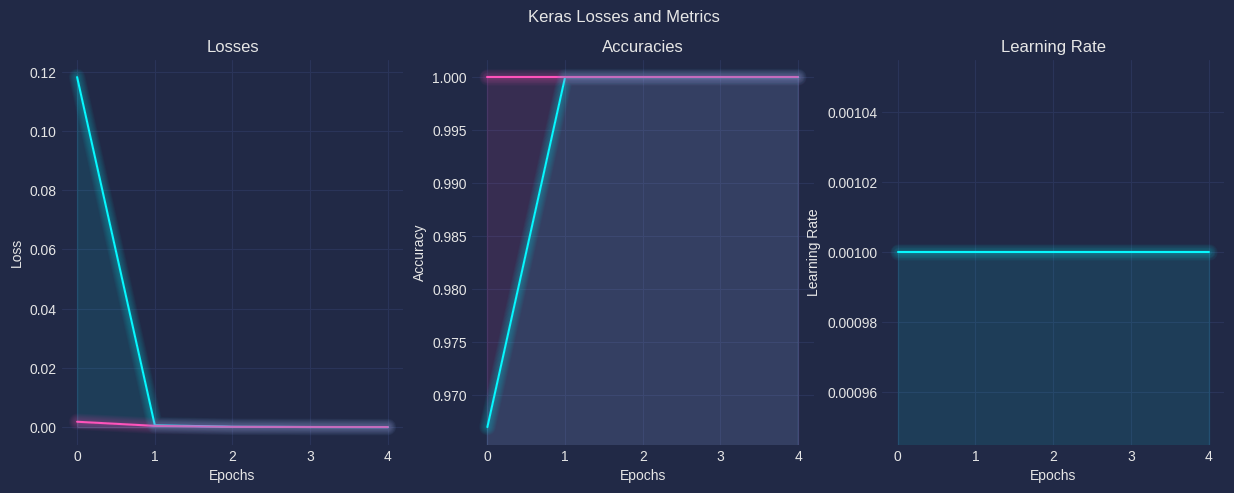

In [ ]:
keras_history = history.history
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Keras Losses and Metrics')

ax[0].plot(keras_history['loss'])
ax[0].plot(keras_history['val_loss'])
ax[0].set_title('Losses')
ax[0].set_ylabel('Loss')

ax[1].plot(keras_history['binary_accuracy'])
ax[1].plot(keras_history['val_binary_accuracy'])
ax[1].set_title('Accuracies')
ax[1].set_ylabel('Accuracy')

ax[2].plot(keras_history['learning_rate'])
ax[2].set_title('Learning Rate')
ax[2].set_ylabel('Learning Rate')

for i in range(3):
    ax[i].set_xlabel('Epochs')
    mplcyberpunk.make_lines_glow(ax=ax[i])
    mplcyberpunk.add_underglow(ax=ax[i])

In [ ]:
target_names = ['Normal', 'Attack']

for model in preds:
    current_pred = preds[model]
    cr = classification_report(y_test, current_pred, target_names=target_names)
    accuracies[model] = accuracy_score(y_test, current_pred)
    print(f'Classification Report for {model}\n {cr}')

Classification Report for RandomForestClassifier
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       798
      Attack       1.00      1.00      1.00        87

    accuracy                           1.00       885
   macro avg       1.00      1.00      1.00       885
weighted avg       1.00      1.00      1.00       885

Classification Report for GradientBoostingClassifier
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       798
      Attack       1.00      1.00      1.00        87

    accuracy                           1.00       885
   macro avg       1.00      1.00      1.00       885
weighted avg       1.00      1.00      1.00       885

Classification Report for LogisticRegression
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       798
      Attack       1.00      1.00      1.00        87

    accuracy                    

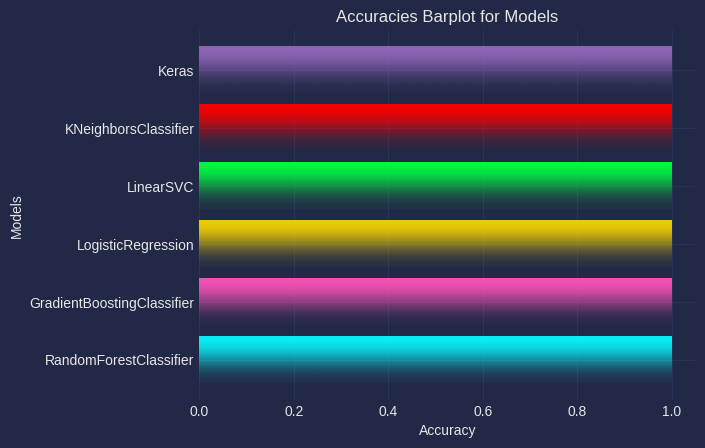

In [ ]:
colors = ["C0", "C1", "C2", "C3", "C4", "C5"]

plt.title('Accuracies Barplot for Models')
plt.xlabel('Accuracy')
plt.ylabel('Models')
bars = plt.barh(list(accuracies.keys()), list(accuracies.values()), color=colors)
mplcyberpunk.add_bar_gradient(bars)

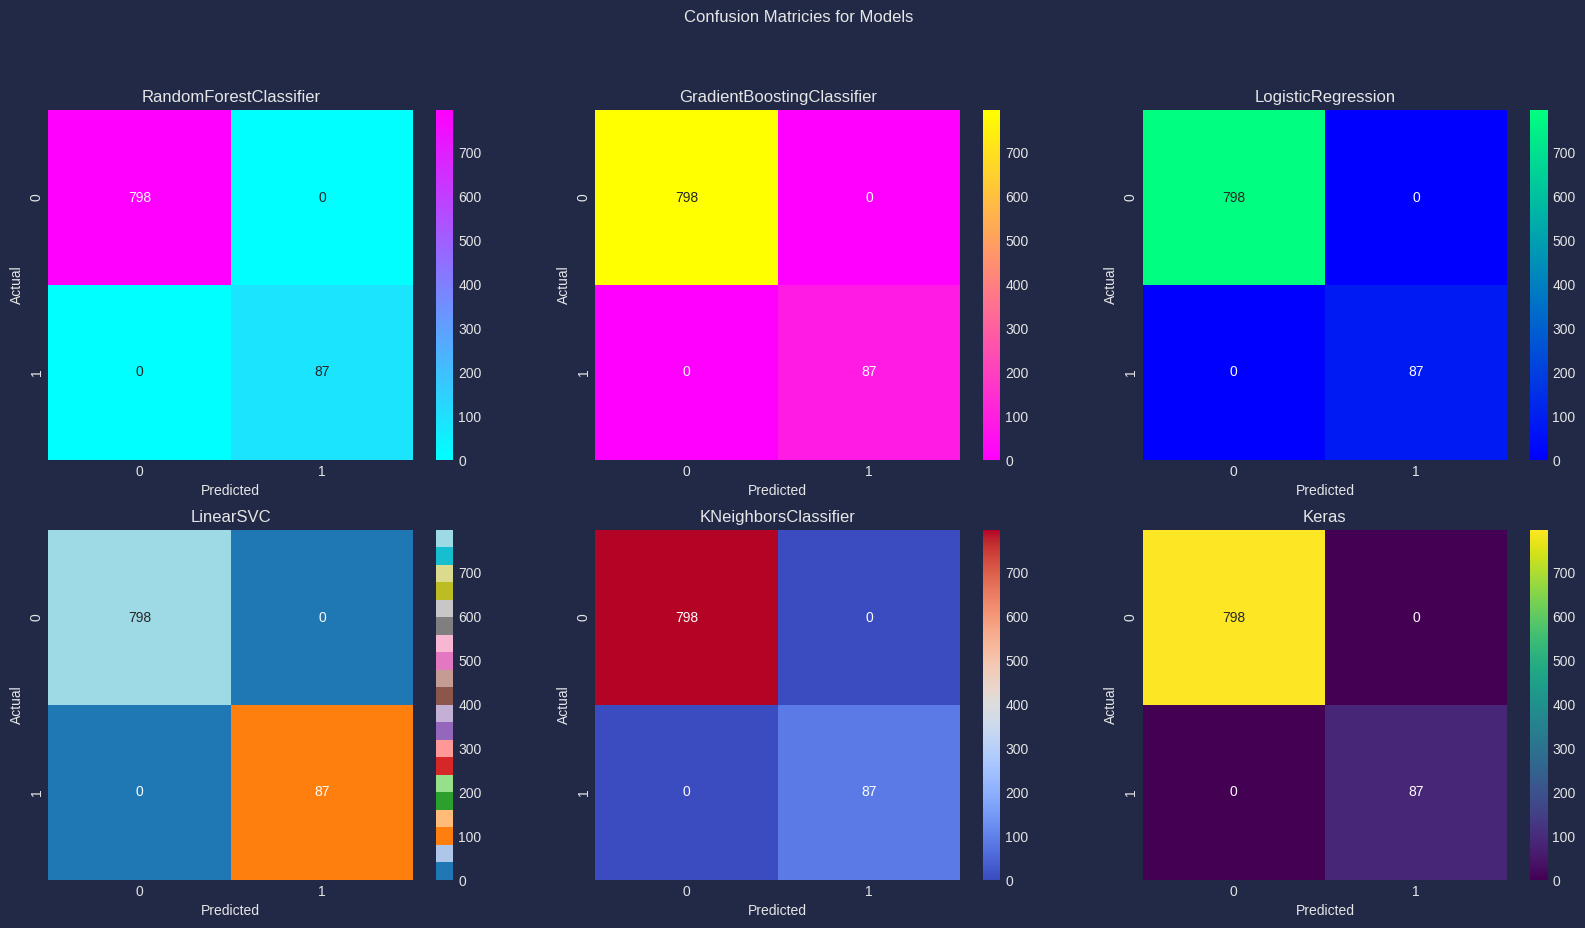

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle("Confusion Matricies for Models")
cmaps = ['cool', 'spring', 'winter', 'tab20', 'coolwarm', 'viridis']

for idx, col in enumerate(preds):
    axes = ax[idx // 3, idx % 3]
    axes.set_title(col)
    cm = confusion_matrix(y_test, preds[col])
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmaps[idx], ax=axes)
    axes.set_ylabel('Actual')
    axes.set_xlabel('Predicted')

In [ ]:
import pickle

# Save the Keras model to a .pkl file
with open('keras_model.pkl', 'wb') as file:
    pickle.dump(keras_model, file)

print("Keras model saved successfully as 'keras_model.pkl'")

Keras model saved successfully as 'keras_model.pkl'


# Task
To ensure the preprocessing steps are reproducible in the Flask application, save the trained `MinMaxScaler` and a dictionary containing all ordinal encoding mappings for categorical features into separate pickle files.

## Save Preprocessing Artifacts

### Subtask:
Save the trained MinMaxScaler and a dictionary containing all ordinal encoding mappings for categorical features into separate pickle files.


**Reasoning**:
To save the ordinal encoding mappings, I need to re-read the original dataset to access the string columns before they were transformed, as instructed. I will then iterate through these columns, apply the `ordinal_encode` function to columns with 10 or fewer unique values, and store the mappings in a dictionary. Finally, I will save both the `MinMaxScaler` object and this dictionary to separate pickle files.



In [ ]:
import pickle
import polars as pl
import polars.selectors as cs

# Re-read the original DataFrame to get untransformed string columns
df_original = pl.read_csv('/content/Network_logs.csv')

# Initialize the dictionary to store ordinal encoding mappings
ordinal_encoding_mappings = {}

# Identify string columns from the original DataFrame
str_cols_original = df_original.select(cs.string())

# The ordinal_encode function was defined in a previous cell (Zqq1_BTQ5Xls)
# It needs to be re-defined here or ensured it's in scope, but typically for Colab,
# functions defined in previous cells are available.
# For robustness, we can include it again if not implicitly available.
# If it is guaranteed to be in scope, this redefinition can be removed.
def ordinal_encode(series : pl.Series) -> dict:
    unique_values = [*series.unique()]
    unique_dict = dict()

    for i in range(len(unique_values)): # Using range for direct index assignment
        unique_dict[unique_values[i]] = i

    return unique_dict

# Iterate through string columns and generate mappings for those with <= 10 unique values
for col_name in str_cols_original.columns:
    col_series = df_original[col_name]
    if col_series.n_unique() <= 10:
        mapping = ordinal_encode(col_series)
        ordinal_encoding_mappings[col_name] = mapping

# Save the trained MinMaxScaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("MinMaxScaler saved successfully as 'scaler.pkl'")

# Save the ordinal encoding mappings dictionary
with open('ordinal_encoding_mappings.pkl', 'wb') as f:
    pickle.dump(ordinal_encoding_mappings, f)
print("Ordinal encoding mappings saved successfully as 'ordinal_encoding_mappings.pkl'")

MinMaxScaler saved successfully as 'scaler.pkl'
Ordinal encoding mappings saved successfully as 'ordinal_encoding_mappings.pkl'


## Outline Flask Application Structure

### Subtask:
Create a basic app.py file for your Flask application, including necessary imports, initializing the Flask app, and defining global variables for the loaded Keras model, scaler, and mappings.


**Reasoning**:
To fulfill the subtask, I will create a code block that represents the content of the `app.py` file, including imports, Flask app initialization, global variables for the model and preprocessors, and a function to load them from the pickle files saved previously.



In [ ]:
import os
from flask import Flask, request, jsonify
import pickle
import numpy as np
import polars as pl
# Keras and TensorFlow imports might be needed depending on how the model is loaded
# For the Keras model saved with pickle, direct keras import might not be strictly necessary if it's already in the pickle,
# but it's good practice to include it if any Keras specific operations are expected.
# Given the current notebook, it's a Keras model, so tensorflow.keras should be imported.
from tensorflow import keras

app = Flask(__name__)

# Define global variables for the loaded artifacts
keras_model = None
scaler = None
ordinal_encoding_mappings = None

def load_artifacts():
    global keras_model, scaler, ordinal_encoding_mappings
    try:
        # Load Keras model
        with open('keras_model.pkl', 'rb') as f:
            # When loading a Keras model saved with pickle, it might contain Keras objects directly.
            # Using keras.models.load_model is typically preferred if the model was saved with model.save()
            # but since it was pickled, we assume pickle.load works.
            keras_model = pickle.load(f)
        print("Keras model loaded successfully.")

        # Load MinMaxScaler
        with open('scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        print("MinMaxScaler loaded successfully.")

        # Load ordinal encoding mappings
        with open('ordinal_encoding_mappings.pkl', 'rb') as f:
            ordinal_encoding_mappings = pickle.load(f)
        print("Ordinal encoding mappings loaded successfully.")

    except Exception as e:
        print(f"Error loading artifacts: {e}")

# Call load_artifacts when the app starts
with app.app_context():
    load_artifacts()

@app.route('/')
def home():
    return "Flask app is running. Model, scaler, and mappings loaded."

# Example route for prediction (to be implemented later)
# @app.route('/predict', methods=['POST'])
# def predict():
#    data = request.get_json(force=True)
#    # Preprocess data using loaded scaler and mappings
#    # Make prediction using loaded keras_model
#    # Return prediction
#    return jsonify({'prediction': 'your_prediction_here'})

if __name__ == '__main__':
    # The host='0.0.0.0' makes the server accessible externally
    # port=5000 is the default Flask port
    app.run(host='0.0.0.0', port=os.environ.get('PORT', 5000))

Keras model loaded successfully.
MinMaxScaler loaded successfully.
Ordinal encoding mappings loaded successfully.
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an a

# Task
Create a Flask application (`app.py`) that includes a preprocessing function to transform raw log data using the loaded `MinMaxScaler` and ordinal encoding mappings, and two endpoints: `/upload_log` to accept log files for prediction and `/predict_text` to accept log text directly, both returning intrusion predictions (Normal/Intrusion) in JSON format. Provide instructions on how to run and interact with the application.

## Implement Preprocessing Function

### Subtask:
Develop a Python function within `app.py` that takes raw log data as input, applies the saved ordinal encoding mappings and the loaded `MinMaxScaler` to transform it, and ensures the output is a NumPy array of shape (1, 7).


**Reasoning**:
To implement the `preprocess_log_data` function as described, I need to generate the full `app.py` content, including imports, Flask app initialization, artifact loading, and the new preprocessing function. This function will convert raw log data (dict) into a Polars DataFrame, apply ordinal encodings using the loaded mappings, cast numerical columns to Float64, drop irrelevant columns, reorder the features to match the trained model's input, convert to a NumPy array, and finally scale the data using the loaded `MinMaxScaler`.



In [ ]:
import os
from flask import Flask, request, jsonify
import pickle
import numpy as np
import polars as pl
from tensorflow import keras

app = Flask(__name__)

# Define global variables for the loaded artifacts
keras_model = None
specified_scaler = None # Renamed to avoid conflict with `scaler` in global state
ordinal_encoding_mappings = None

def load_artifacts():
    global keras_model, specified_scaler, ordinal_encoding_mappings
    try:
        # Load Keras model
        with open('keras_model.pkl', 'rb') as f:
            keras_model = pickle.load(f)
        print("Keras model loaded successfully.")

        # Load MinMaxScaler
        with open('scaler.pkl', 'rb') as f:
            specified_scaler = pickle.load(f)
        print("MinMaxScaler loaded successfully.")

        # Load ordinal encoding mappings
        with open('ordinal_encoding_mappings.pkl', 'rb') as f:
            ordinal_encoding_mappings = pickle.load(f)
        print("Ordinal encoding mappings loaded successfully.")

    except Exception as e:
        print(f"Error loading artifacts: {e}")

# Call load_artifacts when the app starts
with app.app_context():
    load_artifacts()

def preprocess_log_data(log_data: dict) -> np.ndarray:
    # 1. Convert the input dictionary into a Polars DataFrame with a single row
    df_log = pl.DataFrame([log_data])

    # 2. Iterate through the ordinal_encoding_mappings and apply transformations
    for col_name, mapping in ordinal_encoding_mappings.items():
        if col_name in df_log.columns:
            df_log = df_log.with_columns(
                pl.col(col_name).replace(mapping).cast(pl.Float64)
            )

    # 3. Ensure the Port and Payload_Size columns are cast to polars.Float64
    # Note: 'Packet_Size' in instructions is assumed to be 'Payload_Size' based on notebook data.
    numerical_cols_to_cast = ['Port', 'Payload_Size']
    for col in numerical_cols_to_cast:
        if col in df_log.columns:
            df_log = df_log.with_columns(pl.col(col).cast(pl.Float64))

    # 4. Drop Source_IP and Destination_IP columns
    # User_Agent was encoded and kept in the original notebook preprocessing.
    cols_to_drop = ['Source_IP', 'Destination_IP']
    df_log = df_log.drop([col for col in cols_to_drop if col in df_log.columns])

    # 5. Select and reorder the remaining feature columns to match the order used during model training.
    # The feature order derived from the notebook's final DataFrame (Variable #5) is used.
    final_feature_order = [
        'Port',
        'Payload_Size',
        'Request_Type',
        'Protocol',
        'User_Agent',
        'Status',
        'Scan_Type'
    ]
    df_log = df_log.select(final_feature_order)

    # 6. Convert the preprocessed Polars DataFrame into a NumPy array.
    preprocessed_array = df_log.to_numpy()

    # 7. Apply the globally loaded MinMaxScaler (`specified_scaler`) to this NumPy array.
    scaled_array = specified_scaler.transform(preprocessed_array)

    # 8. Return the scaled NumPy array, which should have a shape of (1, 7).
    return scaled_array

@app.route('/')
def home():
    return "Flask app is running. Model, scaler, and mappings loaded."

# Example route for prediction (to be implemented later)
# @app.route('/predict', methods=['POST'])
# def predict():
#    data = request.get_json(force=True)
#    # Preprocess data using loaded scaler and mappings
#    # preprocessed_data = preprocess_log_data(data)
#    # Make prediction using loaded keras_model
#    # prediction = keras_model.predict(preprocessed_data)
#    # Return prediction
#    return jsonify({'prediction': 'your_prediction_here'})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=os.environ.get('PORT', 5000))

Keras model loaded successfully.
MinMaxScaler loaded successfully.
Ordinal encoding mappings loaded successfully.
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an a